In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
# from tensorflow import keras 

# Run in anaconda prompt first:
# conda install -c conda-forge librosa
import librosa
import librosa.display

#from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [2]:
# Make sure you have the following files in the same directory as this ipynb:
# 1. nsynth-test.tfrecord
# 2. nsynth-train.tfrecord
# 3. nsynth-valid.tfrecord

nsynth_test = tf.data.TFRecordDataset(['nsynth-test.tfrecord'])
nsynth_train = tf.data.TFRecordDataset(['nsynth-train.tfrecord'])

In [3]:
def get_features(record):
    # We're only going to use a few features for now
    features = {
        # identifier string, this will be our label
        #"note_str": tf.io.FixedLenFeature(shape=[], dtype=tf.string),
        # MIDI tuning standard value for pitch
        "pitch": tf.io.FixedLenFeature(shape=[], dtype=tf.int64),
        # list of normalized audio 'samples' to represent the sound wave
        "audio": tf.io.FixedLenFeature(shape=[64000], dtype=tf.float32)
    }
    sample = tf.io.parse_single_example(record, features)
    
    return sample

In [4]:
test_ds = list(nsynth_test.take(1000).map(get_features))

In [5]:
# Note about how our audio feature is structured:
#
# 4 seconds * 16000 samples per second = 64000 samples
# We only have one channel (these sound clips are mono)
# Dynamic range of 16-bit PCM WAV (-2^15, 2^15 - 1) normalized to (-1, 1)


# We get the first sample in our test dataset as an example
clip1 = test_ds[0]['audio']

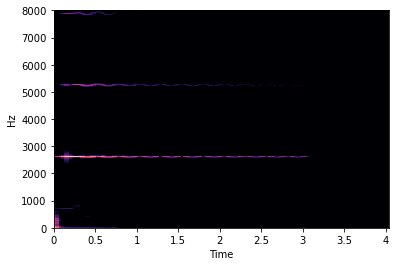

In [6]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(np.array(clip1))), ref=np.max)
librosa.display.specshow(D, y_axis='linear', x_axis='time',sr=16000)

In [7]:
# temporarily borrowing code just for demonstration purposes

def midi_pitch_to_frequency(d):
    return (2**((d-69)/12.0))*440.0

from math import log2, pow

A4 = 440
C0 = A4*pow(2, -4.75)
name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
    
def pitch(freq):
    h = round(12*log2(freq/C0))
    octave = h // 12
    n = h % 12
    return name[n] + str(octave)

f = midi_pitch_to_frequency(100)
print("Frequency: ", f)
print("Note: ", pitch(f))

Frequency:  2637.02045530296
Note:  E7


In [8]:
test_ds[0]['pitch']
# We can observe a few things from the previous 3 results:

# 1. Our first audio clip has midi pitch value 100, which encodes the note E7. 
# 2. The note E7 has the fundamental frequency 2637 Hz.
# 3. The spectogram above has frequency ~2700 Hz most represented.

<tf.Tensor: shape=(), dtype=int64, numpy=100>

In [9]:
# We trimmed 4096 test samples down to 1000 
x_test = np.array([np.array(test_ds[i]['audio']) for i in range(len(test_ds))])
y_test = np.array([np.array(test_ds[i]['pitch']) for i in range(len(test_ds))])

# Trim 289,205 training samples down to 10,000
# Too many samples takes too long to load and uses a lot of RAM
train_ds = list(nsynth_train.take(20000).map(get_features))
x_train = np.array([np.array(train_ds[i]['audio']) for i in range(len(train_ds))])
y_train = np.array([np.array(train_ds[i]['pitch']) for i in range(len(train_ds))])

In [10]:
#pca = PCA(n_components=100) #64000 dimensions => 2 dimensions
#pca_x_test = pca.fit_transform(x_test)
#pca_x_train = pca.fit_transform(x_train)

In [ ]:
#random_forest_predict = random_forest_clf.predict(pca_x_test)
#random_forest_clf = RandomForestClassifier(n_estimators=100)
#random_forest_clf.fit(pca_x_train, y_train)

svm_clf = SVC()
svm_clf.fit(x_train, y_train)
svm_y_predict = svm_clf.predict(x_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

#random_forest_cm = confusion_matrix(y_test, random_forest_predict)
#random_forest_cm
svm_cm = confusion_matrix(y_test, svm_y_predict)
mycolumns = ["Target: " + str(i) for i in range(10,108)]
myindices = ["Predict: " + str(i) for i in range(10,108)]
svm_cm_df = pd.DataFrame(svm_cm, index=myindices, columns=mycolumns)
svm_cm_df

In [ ]:
#print(classification_report(y_test, random_forest_predict))
print(classification_report(y_test, svm_y_predict))